In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib

In [3]:
matplotlib.rcParams["xtick.labelsize"] = 8
matplotlib.rcParams["ytick.labelsize"] = 8
matplotlib.rcParams["axes.labelsize"] = 8
matplotlib.rcParams["axes.titlesize"]= 10
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["legend.title_fontsize"] = 8

#avoid using `plt.subplots(figsize=(3.4, 2.7))` every time
matplotlib.rcParams["figure.figsize"] = [3.4, 2.7]  # APS single column
matplotlib.rcParams["figure.dpi"] = 300  # this primarily affects the size on screen

In [4]:
from matplotlib.offsetbox import AnchoredOffsetbox
class AnchoredScaleBar(AnchoredOffsetbox):
    def __init__(self, transform, sizex=0, sizey=0, labelx=None, labely=None, loc=4,
                 pad=0.1, borderpad=0.1, sep=2, prop=None, barcolor="black", barwidth=None, 
                 **kwargs):
        """
        Draw a horizontal and/or vertical  bar with the size in data coordinate
        of the give axes. A label will be drawn underneath (center-aligned).
        - transform : the coordinate frame (typically axes.transData)
        - sizex,sizey : width of x,y bar, in data units. 0 to omit
        - labelx,labely : labels for x,y bars; None to omit
        - loc : position in containing axes
        - pad, borderpad : padding, in fraction of the legend font size (or prop)
        - sep : separation between labels and bars in points.
        - **kwargs : additional arguments passed to base class constructor
        """
        from matplotlib.patches import Rectangle
        from matplotlib.offsetbox import AuxTransformBox, VPacker, HPacker, TextArea, DrawingArea
        bars = AuxTransformBox(transform)
        if sizex:
            bars.add_artist(Rectangle((0,0), sizex, 0, ec=barcolor, lw=barwidth, fc="none"))
        if sizey:
            bars.add_artist(Rectangle((0,0), 0, sizey, ec=barcolor, lw=barwidth, fc="none"))

        if sizex and labelx:
            self.xlabel = TextArea(labelx)
            bars = VPacker(children=[bars, self.xlabel], align="center", pad=0, sep=sep)
        if sizey and labely:
            self.ylabel = TextArea(labely, textprops={'rotation':90})
            bars = HPacker(children=[self.ylabel, bars], align="center", pad=0, sep=sep)

        AnchoredOffsetbox.__init__(self, loc, pad=pad, borderpad=borderpad,
                                   child=bars, prop=prop, frameon=False, **kwargs)

        
def add_scalebar(ax, matchx=True, matchy=True, hidex=True, hidey=True, **kwargs):
    """ Add scalebars to axes
    Adds a set of scale bars to *ax*, matching the size to the ticks of the plot
    and optionally hiding the x and y axes
    - ax : the axis to attach ticks to
    - matchx,matchy : if True, set size of scale bars to spacing between ticks
                    if False, size should be set using sizex and sizey params
    - hidex,hidey : if True, hide x-axis and y-axis of parent
    - **kwargs : additional arguments passed to AnchoredScaleBars
    Returns created scalebar object
    """
    def f(axis):
        l = axis.get_majorticklocs()
        return len(l)>1 and (l[1] - l[0])
    
    if matchx:
        kwargs['sizex'] = f(ax.xaxis)
        kwargs['labelx'] = str(kwargs['sizex'])
    if matchy:
        kwargs['sizey'] = f(ax.yaxis)
        kwargs['labely'] = str(kwargs['sizey'])
        
    sb = AnchoredScaleBar(ax.transData, **kwargs)
    ax.add_artist(sb)

    if hidex : ax.xaxis.set_visible(False)
    if hidey : ax.yaxis.set_visible(False)
    if hidex and hidey: ax.set_frame_on(False)

    return sb

In [5]:
def _set_size(ax, w, h):
    """
        set the size of an axis, where the size describes the actual area of the plot,
        _excluding_ the axes, ticks, and labels.

        w, h: width, height in inches

        # Example
        ```
            cm = 2.54
            fig, ax = plt.subplots()
            ax.plot(stuff)
            fig.tight_layout()
            _set_size(ax, 3.5*cm, 4.5*cm)
        ```
    """
    # https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w) / (r - l)
    figh = float(h) / (t - b)
    ax.figure.set_size_inches(figw, figh)

In [34]:
class spike_to_fluo__base:
    def __init__(self, conv_params):
        self.tau_r = conv_params['tau_r'] #[ms]
        self.tau_d = conv_params['tau_d'] #[ms]
        self.sigma_i = conv_params['sigma_i'] #[1]
    
    def calc_convolve(self, t, s_t):
        """ takes s_t which is a timeseries"""
        num_times = len(t)

        c_t = np.zeros(num_times)

        num_spks = np.count_nonzero(s_t)

        c_i_t = np.zeros((num_spks, num_times))

        spk_times = np.nonzero(s_t)[0]

        for i_spk, t_spk in enumerate(spk_times):
            c_i_t[i_spk] = s_t[t_spk] * np.exp(-(t-t_spk)/self.tau_d) + np.random.normal(0,self.sigma_i, size=num_times)
            c_i_t[i_spk][t<t_spk] = 0
            c_i_t[i_spk][c_i_t[i_spk]<0] = 0
        
        c_t = np.sum(c_i_t, axis=0)
        return c_t

    def plot_convolve(self, t, s_t, c_t, ax=None):
        if not ax:
            fig, ax = plt.subplots(figsize=(5,3))

        spk_times = np.nonzero(s_t)[0]
        ax.plot(t/1000, c_t, color='blue', label='convolved spikes')
        ax.set_xlim(t[0]/1000, t[-1]/1000)

    def plot_synfluo(self, t, s_t, f_t, ax=None):
        if not ax:
            fig, ax = plt.subplots(figsize=(5,3))

        spk_times = np.nonzero(s_t)[0]
        ax.eventplot(spk_times/1000, 
                     colors='black', lineoffsets=-0.5, linelengths=0.2, linewidths=1, color='black', label='spikes', clip_on=False)
        ax.plot(t[::33]/1000, f_t[::33], 
                color='blue', label='synthesised fluo', clip_on=False)

        ax.set_xlim(t[0]/1000, t[-1]/1000)
        _set_size(ax,4,1.5)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

        scalebar = AnchoredScaleBar(ax.transData,
                           1, 0.1, '1 s', r'$0.5' + r'\Delta F / F$', loc=3,
                           pad=0, borderpad=-4)
        ax.add_artist(scalebar)
    
    def plot_synfluo_obscured(self, t, s_t, f_t, stim_t, ax=None):
        if not ax:
            fig, ax = plt.subplots(figsize=(5,3))

        stim_onset = np.nonzero(stim_t)[0][0]
        stim_offset = np.nonzero(stim_t)[0][-1]

        spk_times = np.nonzero(s_t)[0]
        ax.eventplot(spk_times/1000, 
                     colors='black', lineoffsets=-2, linelengths=2, linewidths=1, color='black', label='spikes', clip_on=False)

        ax.plot(t[:stim_onset][::33]/1000, f_t[:stim_onset][::33], color='blue', label='synthesised fluo', clip_on=False)

        ax.plot(t[stim_offset:][::33]/1000, f_t[stim_offset:][::33], color='blue', clip_on=False)
        ax.axvspan(t[stim_onset]/1000, t[stim_offset]/1000, alpha=0.5, color='pink', label='photostim artifact')
        
        ax.set_xlim(t[0]/1000, t[-1]/1000)
        _set_size(ax,4,1.5)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

        scalebar = AnchoredScaleBar(ax.transData,
                           1, 0.5, '1 s', r'$0.5' +r'\Delta F / F$', loc=3,
                           pad=0, borderpad=-4)
        ax.add_artist(scalebar)
        

class spike_to_fluo__sig(spike_to_fluo__base):
    def __init__(self, conv_params, sig_params):
        super().__init__(conv_params)
        self.k_sig = sig_params['k_sig']
        self.c_half = sig_params['c_half']
        self.F_max = sig_params['F_max']
        self.sigma_e = sig_params['sigma_e']

    def calc_fluo(self, t, c_t):
        num_times = len(t)

        F_syn_t = self.F_max / (1+np.exp(-self.k_sig*(c_t-self.c_half))) + np.random.normal(0,self.sigma_e, size=num_times)

        return F_syn_t
    
class spike_to_fluo__linear(spike_to_fluo__base):
    def __init__(self, conv_params, linear_params):
        super().__init__(conv_params)
        self.F_max = linear_params['F_max']
        self.F_zero = linear_params['F_zero']
        self.sigma_e = linear_params['sigma_e']

    def calc_fluo(self, t, c_t):
        num_times = len(t)

        F_syn_t = self.F_max * c_t + self.F_zero + np.random.normal(0,self.sigma_e, size=num_times)

        return F_syn_t

class spike_to_fluo__hill(spike_to_fluo__base):
    def __init__(self, conv_params, hill_params):
        super().__init__(conv_params)
        self.F_max = hill_params['F_max']
        self.n_order = hill_params['n_order']
        self.K_d = hill_params['K_d']
        self.sigma_e = hill_params['sigma_e']
    
    def calc_fluo(self, t, c_t):
        num_times = len(t)

        F_syn_t = self.F_max * c_t ** self.n_order / (c_t ** self.n_order + self.K_d) + np.random.normal(0,self.sigma_e, size=num_times)

        return F_syn_t


In [ ]:
frozen_poisson = np.load('frozen_poisson.npy')

In [8]:
seconds_pre = 3 #[s]
seconds_post = 7 #[s]

/usr/local/anaconda3/envs/DEEPLABCUT_M1/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: "color" keyword argument will be ignored


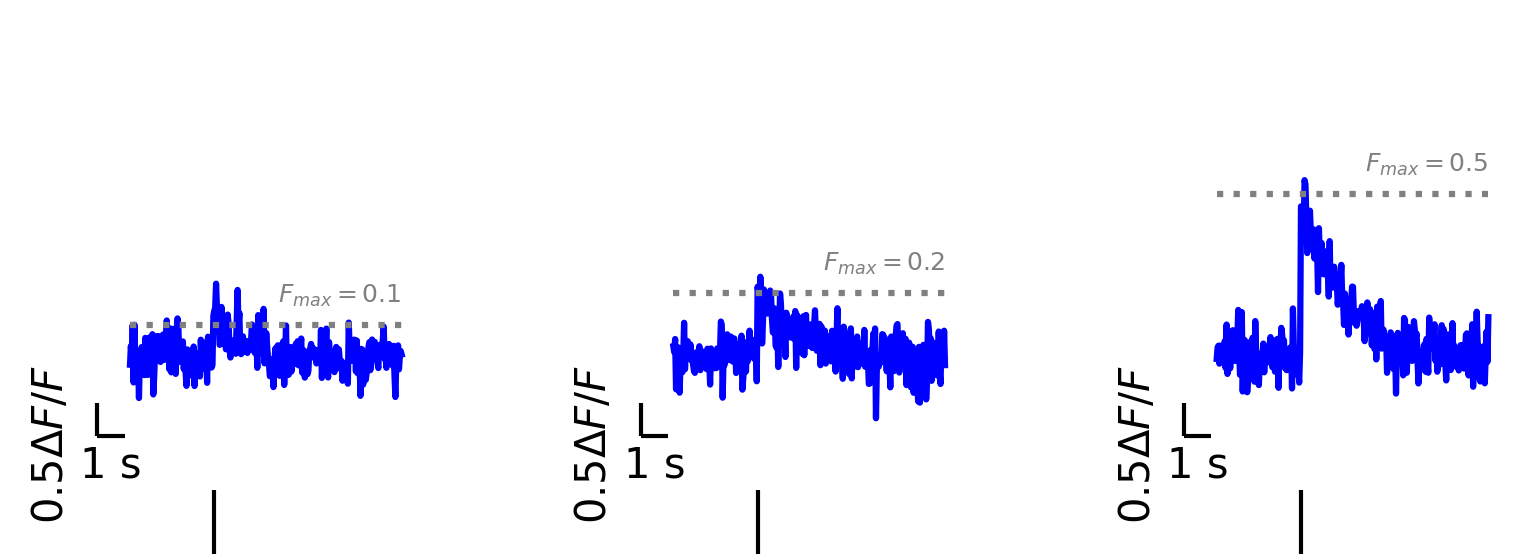

In [35]:
Fmax_array = np.asarray([0.1,0.2,0.5])

t = np.arange(0,1+(seconds_pre+seconds_post)*1000) #[ms]
s_poisson_t = np.random.poisson(1/1000, size=len(t))

fig, ax = plt.subplots(1,3,figsize=(5,2), dpi=300)
#fig.suptitle('Synthesized fluorescence response to single spikes', weight='bold')

# top row
for ax_id, F_max in enumerate(Fmax_array):
    base_params = {'tau_r':100, 'tau_d':1500, 'sigma_i':0}
    s_to_f_basemodel = spike_to_fluo__base(base_params)

    lin_params = {'F_max':F_max, 'F_zero':0, 'sigma_e':0.05}
    s_to_f_linmodel = spike_to_fluo__linear(base_params, lin_params)

    s_stim_t = np.zeros_like(t)
    p_stim_t = np.zeros_like(t)

    s_stim_t[3100] = 1
    p_stim_t[3000:3500] = 1

    s_t = np.copy(s_stim_t)

    c_t = s_to_f_basemodel.calc_convolve(t, s_t)

    f_t = s_to_f_linmodel.calc_fluo(t, c_t)

    s_to_f_linmodel.plot_synfluo(t, s_t, f_t, ax=ax[ax_id])

    ax[ax_id].axhline(F_max, color='grey', linestyle=':')
    ax[ax_id].text(10, F_max+0.05, r'$F_{max}=$'+'{}'.format(F_max), horizontalalignment='right', verticalalignment='bottom', fontsize=6, color='grey')
    ax[ax_id].set_xticks([])
    ax[ax_id].set_yticks([])
    ax[ax_id].set_ylim(-0.2,1)

fig.tight_layout()
plt.subplots_adjust(wspace=1)
fig.savefig('SingleSpike.pdf')

In [ ]:
frozen_poisson = np.load('frozen_poisson.npy')

/usr/local/anaconda3/envs/DEEPLABCUT_M1/lib/python3.7/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: "color" keyword argument will be ignored


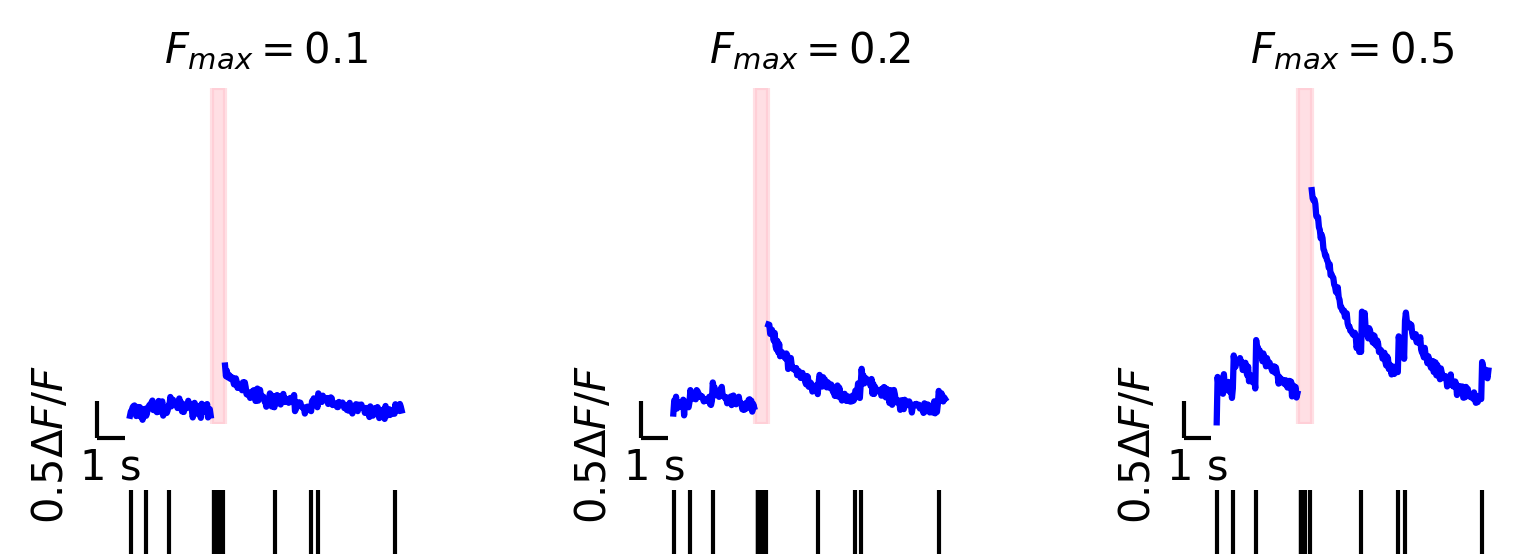

In [36]:
Fmax_array = np.asarray([0.1,0.2,0.5])

t = np.arange(0,1+(seconds_pre+seconds_post)*1000) #[ms]
s_poisson_t = np.copy(frozen_poisson)

fig, ax = plt.subplots(1,3,figsize=(5,2), dpi=300)
#fig.suptitle('Synthesized fluorescence response to five spikes on top of Poisson Background', weight='bold')

# second row
for ax_id, F_max in enumerate(Fmax_array):
    base_params = {'tau_r':100, 'tau_d':1500, 'sigma_i':0}
    s_to_f_basemodel = spike_to_fluo__base(base_params)

    lin_params = {'F_max':F_max, 'F_zero':0, 'sigma_e':0.05}
    s_to_f_linmodel = spike_to_fluo__linear(base_params, lin_params)

    s_stim_t = np.zeros_like(t)
    p_stim_t = np.zeros_like(t)

    s_stim_t[3100] = 1
    s_stim_t[3110] = 1
    s_stim_t[3120] = 1
    s_stim_t[3130] = 1
    s_stim_t[3140] = 1
    p_stim_t[3000:3500] = 1

    s_t = s_stim_t + s_poisson_t

    c_t = s_to_f_basemodel.calc_convolve(t, s_t)

    f_t = s_to_f_linmodel.calc_fluo(t, c_t)

    ax[ax_id].set_title(r'$F_{max}=$'+'{}'.format(F_max))
    ax[ax_id].set_xticks([])
    ax[ax_id].set_yticks([])
    ax[ax_id].set_ylim(-0.1,4.5)
    
    s_to_f_linmodel.plot_synfluo_obscured(t, s_t, f_t, p_stim_t, ax=ax[ax_id])

fig.tight_layout()
plt.subplots_adjust(wspace=1)
fig.savefig('FiveSpikes.pdf')